In [4]:
import functools
import jax
import os

from datetime import datetime
from jax import numpy as jnp
import matplotlib.pyplot as plt

from IPython.display import HTML, clear_output
import mediapy

import brax

import flax
from brax import envs
from brax.io import model
from brax.io import json
from brax.io import html
from brax.training.agents.ppo import train as ppo
from brax.training.agents.sac import train as sac

from task_aware_skill_composition.brax.envs.car import Car
from task_aware_skill_composition.brax.envs.drone import Drone

In [5]:
backend = 'mjx'

env = Car(backend=backend)
# env = Drone(backend=backend)

# env = envs.get_environment(env_name="ant", backend=backend)

jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

In [6]:
HTML(html.render(env.sys, [state.pipeline_state]))

NameError: name 'state' is not defined

In [7]:
train_fn = functools.partial(ppo.train,
                             num_timesteps=50_000_000,
                             num_evals=10,
                             reward_scaling=10,
                             episode_length=1000,
                             normalize_observations=True,
                             action_repeat=1,
                             unroll_length=5,
                             num_minibatches=32,
                             num_updates_per_batch=4,
                             discounting=0.97,
                             learning_rate=3e-4,
                             entropy_cost=1e-2,
                             num_envs=4096,
                             batch_size=2048,
                             seed=1)

In [5]:
# For Plotting Training Progress

max_y = 8000
min_y = 0

xdata, ydata = [], []
times = [datetime.now()]

def progress(num_steps, metrics):
  times.append(datetime.now())
  xdata.append(num_steps)
  ydata.append(metrics['eval/episode_reward'])
  clear_output(wait=True)
  plt.xlim([0, train_fn.keywords['num_timesteps']])
  plt.ylim([min_y, max_y])
  plt.xlabel('# environment steps')
  plt.ylabel('reward per episode')
  plt.plot(xdata, ydata)
  plt.show()


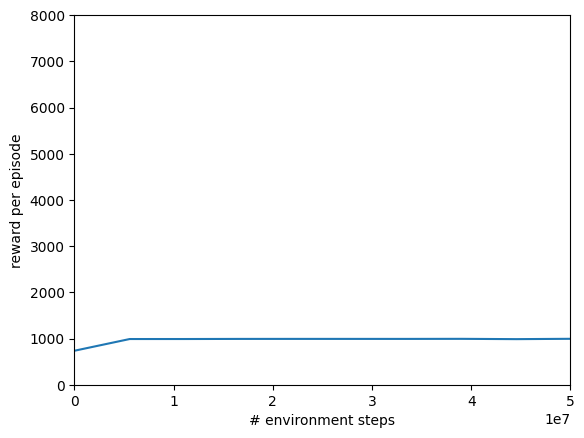

In [6]:
make_inference_fn, params, _ = train_fn(
  environment=env,
  progress_fn=progress
)

# Visualizing Env with Fixed Action Rollout

In [8]:
# state = jit_reset(rng)
# state.observation

In [9]:
# initialize the state
rng = jax.random.PRNGKey(0)
state = jit_reset(rng)

# grab a trajectory
rollout = [state.pipeline_state]
n_steps = 100
render_every = 1

ctrl = jnp.ones(env.action_size) * 15.0
print(f"Made ctrl = {ctrl}")

for i in range(n_steps):
  state = jit_step(state, ctrl)

  if state.done:
      break

  rollout.append(state.pipeline_state)

Made ctrl = [15. 15.]


In [10]:
mediapy.show_video(env.render(rollout, camera='track'), fps=1.0 / env.dt)